In [1]:
from sklearn import ensemble, model_selection, tree, metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ejercicio 1

Pensamos en usar 20% de test para tener mas confianza en los resultados de nuestros modelos. 10% nos parecio muy bajo (50 datos).

Vamos a usar K-Fold para validar el modelo con el fine-tuning.

(?) usar stratified en test

In [2]:
datos = pd.read_csv("datos/data.csv")
datos = datos.sample(frac=1).reset_index(drop=True) # Permuto las filas al azar x si estaban ordenadas

y = datos['target']
X = datos.iloc[:, :-1]

## Exploratorio
¿Están balanceadas las clases? ¿Cuál es el dominio de c/variable?

In [3]:
y.describe()

count    500.000000
mean       0.314000
std        0.464581
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

Nos muestra que el 31% de las instancias son positivas

In [4]:
X.describe()

,v000,v001,v002,v003,v004,v005,v006,v007,v008,v009,...,v190,v191,v192,v193,v194,v195,v196,v197,v198,v199
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.009267,0.311966,0.307209,0.097470,-0.607017,0.044792,0.355969,0.022677,-0.035567,0.103722,...,0.142736,2.328988,0.007893,-0.020766,-0.086899,0.063581,-0.038312,0.035427,0.006325,-0.051118
std,0.975490,3.912558,3.767061,3.610366,3.704771,0.975781,14.060713,0.954003,1.002238,1.015869,...,3.986716,15.010389,0.938104,0.996816,1.020212,1.016698,0.974231,0.970219,1.043570,1.065060
min,-2.752396,-12.572314,-11.683991,-9.006606,-13.404165,-2.925299,-48.638707,-3.251326,-2.406738,-3.160870,...,-14.532847,-54.029582,-2.408729,-2.970611,-3.249889,-3.767649,-3.540205,-3.008173,-3.392034,-3.427479
25%,-0.743840,-2.127998,-2.127213,-2.383809,-2.809018,-0.589888,-8.935025,-0.635025,-0.713722,-0.576184,...,-2.495412,-8.039357,-0.603277,-0.712197,-0.786245,-0.610677,-0.701960,-0.699451,-0.749854,-0.683977
50%,0.003287,0.395026,0.347173,0.117205,-0.526886,0.028390,0.757326,-0.027957,-0.086581,0.099395,...,0.551526,1.850865,0.020075,-0.009439,-0.141925,0.085369,-0.039375,0.078905,-0.040844,-0.086783
75%,0.637673,3.001048,2.873274,2.515734,1.862409,0.727605,9.139917,0.648196,0.636730,0.733565,...,2.889129,12.830106,0.669860,0.659035,0.570697,0.717711,0.615251,0.716747,0.750853,0.608635
max,2.909961,13.080686,10.988238,11.525223,12.723617,2.969670,37.531665,2.760723,3.574362,3.559263,...,10.335808,47.848053,2.240678,2.445577,3.561875,2.657823,3.161963,2.740900,3.276697,2.944781


200 boxplots son ilegibles, pero de esta tablita rescatamos que todas las variables están bastante centradas: tienen medias y medianas cercanas a 0. Cada columna parece tener rango distinto (algunas entre -3, 3 otras -10, 10, etc.)

In [5]:
def desarrollo_evaluacion(X, y, prop_train):
    return X[:int(len(X)*prop_train)], y[:int(len(X)*prop_train)], X[int(len(X)*prop_train):], y[int(len(X)*prop_train):]

In [6]:
X_train, y_train, X_test, y_test = desarrollo_evaluacion(X, y, 0.8)

# Ejercicio 2

In [7]:
arbol = tree.DecisionTreeClassifier(max_depth=3)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

(!) average_precision es ~AUPRC

In [8]:
metricas = ['accuracy', 'roc_auc', 'average_precision']
scores = model_selection.cross_validate(arbol, X_train, y_train, cv = 5, scoring = metricas, return_train_score=True, return_estimator=True, return_indices=True)

In [9]:
for metrica in list(scores.keys())[4:]:
    scores[metrica] = {'permutacion': scores[metrica], 'promedio': np.mean(scores[metrica])}

scores

{'fit_time': array([0.03214645, 0.02656865, 0.02245569, 0.02144194, 0.02292705]),
 'score_time': array([0.00673103, 0.00644803, 0.00828409, 0.01179624, 0.00734901]),
 'estimator': [DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3)],
 'indices': {'train': (array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
           93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
          106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
          119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
          132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
          145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
          158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
          171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
     

(?) cross_val_predict

In [10]:
pred_folds = np.array([])
real_folds = np.array([])
for i in range(5):
    pred_folds = np.concatenate((pred_folds, scores['estimator'][i].predict(X_train.iloc[scores['indices']['test'][i]])))
    real_folds = np.concatenate((real_folds, y_train[scores['indices']['test'][i]]))

In [11]:
global_scores = {'accuracy': metrics.accuracy_score(real_folds, pred_folds),
                 'AUPRC': metrics.average_precision_score(real_folds, pred_folds),
                 'AUCROC': metrics.roc_auc_score(real_folds, pred_folds)}
global_scores

{'accuracy': 0.6925, 'AUPRC': 0.3621174863387978, 'AUCROC': 0.5832940205212879}

In [12]:
grilla = model_selection.ParameterGrid({'max_depth': [3, 5, None], 'criterion': ['gini', 'entropy']})
scores_grilla = []

for params in grilla:
    arbol = tree.DecisionTreeClassifier(**params)
    scores_grilla += [model_selection.cross_validate(arbol, X_train, y_train, cv=5, return_train_score=True)]
    scores_grilla[-1]['promedio_test'] = np.mean(scores_grilla[-1]['test_score'])
    scores_grilla[-1]['promedio_train'] = np.mean(scores_grilla[-1]['train_score'])

In [13]:
[param for param in grilla]

[{'criterion': 'gini', 'max_depth': 3},
 {'criterion': 'gini', 'max_depth': 5},
 {'criterion': 'gini', 'max_depth': None},
 {'criterion': 'entropy', 'max_depth': 3},
 {'criterion': 'entropy', 'max_depth': 5},
 {'criterion': 'entropy', 'max_depth': None}]

In [14]:
scores_grilla

[{'fit_time': array([0.02071309, 0.02004623, 0.02002668, 0.02089882, 0.02241325]),
  'score_time': array([0.00207782, 0.00200105, 0.00382137, 0.00226927, 0.00378585]),
  'test_score': array([0.6375, 0.7375, 0.7   , 0.675 , 0.675 ]),
  'train_score': array([0.809375, 0.834375, 0.84375 , 0.8375  , 0.7875  ]),
  'promedio_test': 0.6849999999999999,
  'promedio_train': 0.8225},
 {'fit_time': array([0.0317204 , 0.04435182, 0.03263927, 0.03636026, 0.03928924]),
  'score_time': array([0.00234103, 0.00246787, 0.00234079, 0.00406814, 0.00381589]),
  'test_score': array([0.6375, 0.725 , 0.6375, 0.5375, 0.6625]),
  'train_score': array([0.928125, 0.9375  , 0.940625, 0.921875, 0.8875  ]),
  'promedio_test': 0.6399999999999999,
  'promedio_train': 0.9231250000000001},
 {'fit_time': array([0.06645775, 0.05001402, 0.04048109, 0.05135846, 0.06567359]),
  'score_time': array([0.00385308, 0.00237751, 0.00240207, 0.00435781, 0.00237107]),
  'test_score': array([0.6   , 0.75  , 0.6125, 0.575 , 0.6625]),
 

(!) faltan conclusiones

- los ultimos dan 1 porque tienen altura maxima inf
- decir algo de entropy vs. gini

# Ejercicio 3

In [15]:
from sklearn import neighbors, svm, discriminant_analysis, naive_bayes

In [16]:
tree_params = {'max_depth': [i for i in range(1, 20)], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2']}
knn_params = {'n_neighbors': [i for i in range(1, 20)], 'metric': ['l1', 'l2', 'cosine']}
svm_params = {'C': np.linspace(1, 10, 20), 'tol': [10 ** -i for i in range(1, 6)], 'kernel': ['linear', 'rbf']}
lda_params = {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 1.0]}
naive_params = {'priors': [[i, 1-i] for i in np.linspace(0, 1, 100)]}

In [17]:
modelos = {
    tree.DecisionTreeClassifier: tree_params,
    neighbors.KNeighborsClassifier: knn_params,
    svm.SVC: svm_params,
    discriminant_analysis.LinearDiscriminantAnalysis: lda_params,
    naive_bayes.GaussianNB: naive_params
}

results = {}
mejores = []

for modelo, params in modelos.items():
    search = model_selection.RandomizedSearchCV(estimator=modelo(),
                                       param_distributions=params,
                                       scoring='roc_auc')
    search.fit(X_train, y_train)
    results[modelo] = search.cv_results_
    mejores.append(search.best_estimator_)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 637, in fit
    self._solve_eigen(
  File "/

In [18]:
excl = ['params', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_test_score', 'rank_test_score']
for modelo in modelos:
    print(pd.DataFrame(results[modelo]).drop(excl, axis=1).sort_values('mean_test_score', ascending=False))
    print('\n\n')

  param_max_features param_max_depth param_criterion  mean_test_score
7               sqrt               5         entropy         0.599471
4               sqrt              11            gini         0.592202
2               log2               9            gini         0.582443
1               sqrt              14            gini         0.571282
6               sqrt               2            gini         0.552005
9               log2               8            gini         0.551074
0               log2              18         entropy         0.540506
8               log2               7        log_loss         0.534774
3               sqrt              18         entropy         0.526985
5               log2               2        log_loss         0.524492



  param_n_neighbors param_metric  mean_test_score
4                17       cosine         0.797656
1                16           l1         0.796351
2                 5       cosine         0.793474
0                 8       c

In [19]:
for modelo in results:
    print(modelo)
    print(max(results[modelo]['mean_test_score']))

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
0.5994705086580087
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
0.7976556818181818
<class 'sklearn.svm._classes.SVC'>
0.8643636363636364
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
0.8448257575757575
<class 'sklearn.naive_bayes.GaussianNB'>
0.7707718614718615


# Ejercicio 4

Arbol de decision, LDA, SVM

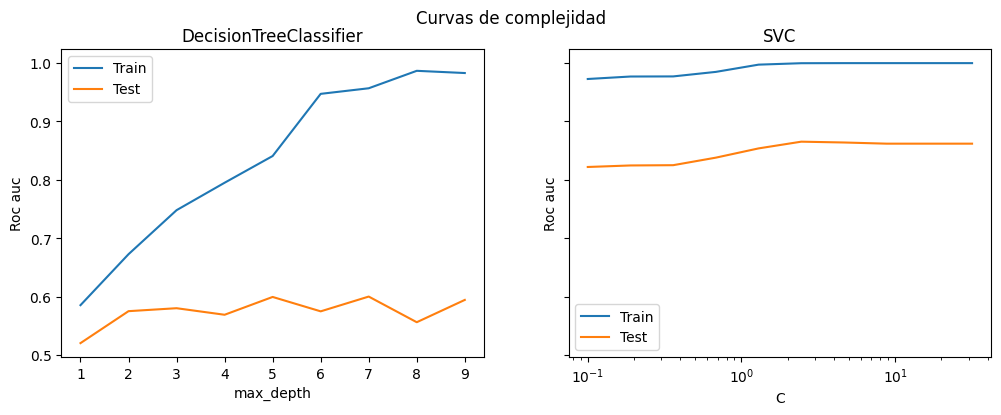

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey='row')

model_selection.ValidationCurveDisplay.from_estimator(
    mejores[0], X_train, y_train, param_name='max_depth', param_range=[i for i in range(10)], std_display_style=None, scoring='roc_auc', ax=ax[0]
)
ax[0].set_title(mejores[0].__class__.__name__)

model_selection.ValidationCurveDisplay.from_estimator(
    mejores[2], X_train, y_train, param_name='C', param_range=np.logspace(-1, 1.5, 10), std_display_style=None, scoring='roc_auc', ax=ax[1]
)
ax[1].set_title(mejores[2].__class__.__name__)

fig.suptitle('Curvas de complejidad')

plt.savefig('curvas_complejidad.png')

(DecisionTree) aumentar max depth hace que el modelo overfittee. Sin embargo, en evaluacion la performance no mejora.

(SVM) A mayores valores de C el modelo es menos "regular". SVM se satura alrededor de C=5 y el score de test converge (ademas train llega al maximo, 1).

In [21]:
# Usamos siempre el mismo conjunto de validacion (el ultimo 20%, porque permutamos los datos)
train_test_indices = [([i for i in range(320)], [i for i in range(320, 400)])]

In [22]:
[(i, modelo) for i, modelo in enumerate(mejores)]

[(0,
  DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='sqrt')),
 (1, KNeighborsClassifier(metric='cosine', n_neighbors=17)),
 (2, SVC(C=3.8421052631578947, tol=0.1)),
 (3, LinearDiscriminantAnalysis(shrinkage=0.5, solver='lsqr')),
 (4, GaussianNB(priors=[0.797979797979798, 0.202020202020202]))]

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/_respon

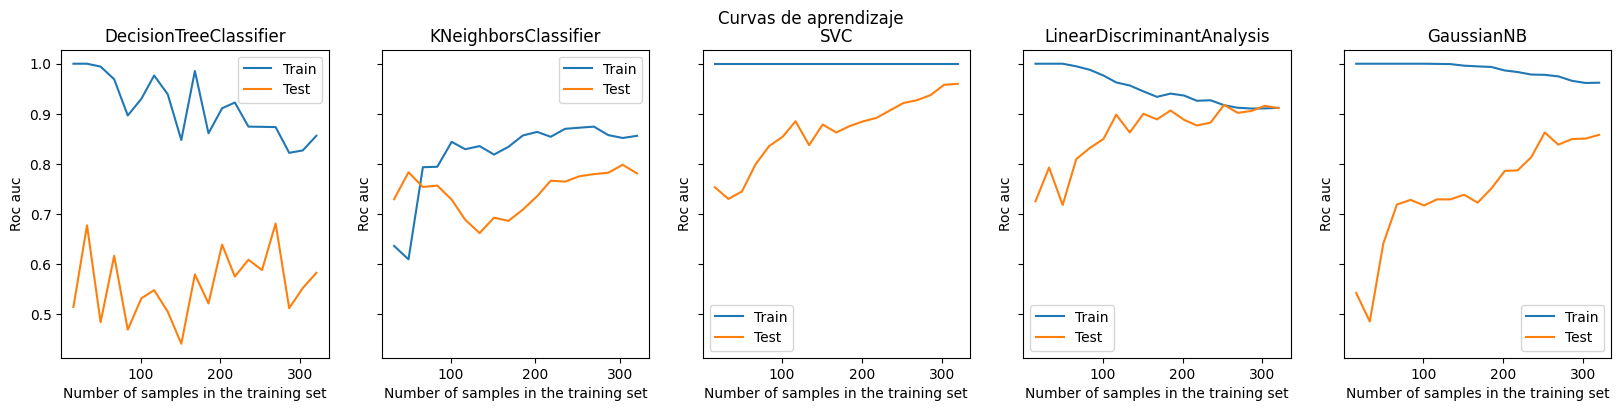

In [23]:
fig, ax = plt.subplots(1, len(mejores), figsize=(20,4), sharey='row')
for i, modelo in enumerate(mejores):
    model_selection.LearningCurveDisplay.from_estimator(
        modelo, X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), scoring='roc_auc', cv=train_test_indices, ax=ax[i]
    )
    ax[i].set_title(modelo.__class__.__name__)
fig.suptitle('Curvas de aprendizaje')

plt.savefig('curvas_aprendizaje.png')

Para el arbol de decision mas datos no mejora el rendimiento. El modelo ya separo el espacio lo mejor que pudo con los parametros dados.

El grafico parece haber convergido. Sin embargo, es creciente hasta el final asi que podria mejorar con mas datos de entrenamiento.

Para LDA la curva de aprendizaje tambien es creciente, asi que el modelo no llego a overfitear (baja varianza o sesgo alto). Con mas datos puede mejorar la performance.

## Random forest

In [24]:
random_forest = ensemble.RandomForestClassifier(n_estimators=200)

(!) usar randomizedsearchcv para los otros parametros

In [25]:
search = model_selection.RandomizedSearchCV(random_forest, param_distributions={'max_depth': [i for i in range(20)], 'criterion': ['gini', 'entropy', 'log_loss']})
search.fit(X_train, y_train)
pd.DataFrame(search.cv_results_).sort_values('mean_test_score', ascending=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/cod

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.625206,0.058488,0.010304,0.002154,8,log_loss,"{'max_depth': 8, 'criterion': 'log_loss'}",0.7125,0.7250,0.7125,0.7250,0.7250,0.7200,0.006124,1
7,0.618495,0.028706,0.009241,0.000093,11,entropy,"{'max_depth': 11, 'criterion': 'entropy'}",0.7125,0.7375,0.7125,0.7125,0.7000,0.7150,0.012247,2
2,0.623111,0.024290,0.010765,0.002232,16,entropy,"{'max_depth': 16, 'criterion': 'entropy'}",0.7125,0.7250,0.7125,0.7000,0.7000,0.7100,0.009354,3
8,0.619345,0.051216,0.009206,0.000128,9,entropy,"{'max_depth': 9, 'criterion': 'entropy'}",0.7000,0.7375,0.7000,0.7125,0.6875,0.7075,0.016956,4
0,0.491816,0.022791,0.008904,0.000123,4,log_loss,"{'max_depth': 4, 'criterion': 'log_loss'}",0.7000,0.7375,0.7000,0.6875,0.7000,0.7050,0.016956,5
4,0.637894,0.025842,0.010064,0.001493,19,log_loss,"{'max_depth': 19, 'criterion': 'log_loss'}",0.7000,0.7375,0.7000,0.6875,0.7000,0.7050,0.016956,5
1,0.423437,0.022358,0.008999,0.000328,4,gini,"{'max_depth': 4, 'criterion': 'gini'}",0.7000,0.7125,0.7000,0.6875,0.7000,0.7000,0.007906,7
9,0.640433,0.041565,0.010161,0.001127,19,entropy,"{'max_depth': 19, 'criterion': 'entropy'}",0.6875,0.7125,0.7000,0.6875,0.7000,0.6975,0.009354,8
6,0.255513,0.010617,0.009096,0.001146,1,log_loss,"{'max_depth': 1, 'criterion': 'log_loss'}",0.7000,0.7000,0.7000,0.6875,0.6875,0.6950,0.006124,9
5,0.000590,0.000083,0.000000,0.000000,0,gini,"{'max_depth': 0, 'criterion': 'gini'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


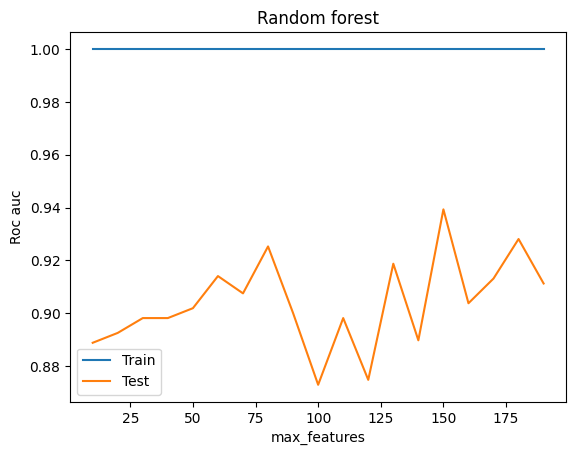

In [26]:
np.random.seed(123)
random_forest = search.best_estimator_
model_selection.ValidationCurveDisplay.from_estimator(random_forest, X_train, y_train, param_name='max_features', param_range=[i for i in range(0, 200, 10)], std_display_style=None, cv=train_test_indices, scoring='roc_auc')
plt.title('Random forest')
plt.savefig('random_forest_complejidad.png')

Para los datos, max_features no mejora el rendimiento del random forest.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/_respon

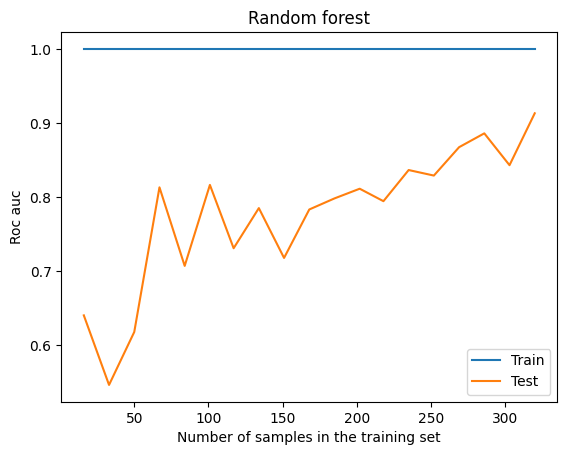

In [27]:
np.random.seed(123)
model_selection.LearningCurveDisplay.from_estimator(random_forest, X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), cv=train_test_indices, scoring='roc_auc')
plt.title('Random forest')
plt.savefig('random_forest_aprendizaje.png')

El rendimiento en evaluacion mejora con mas instancias.

## Ejercicio 5

In [28]:
X_held_out = pd.read_csv('datos/X_held_out.csv')
X_held_out

,v000,v001,v002,v003,v004,v005,v006,v007,v008,v009,...,v190,v191,v192,v193,v194,v195,v196,v197,v198,v199
0,-1.106151,-5.611131,2.712683,-0.529517,-3.831639,0.672653,5.333427,0.108881,0.069763,0.609721,...,-2.388832,-3.575021,-0.195262,-1.329819,-0.615811,-0.149399,0.976335,0.245581,-1.301849,0.729059
1,-0.266336,-2.918979,-1.006739,-0.096504,-3.009074,0.297644,-16.247286,0.011176,1.517002,-0.145927,...,-0.289372,-6.945991,1.973832,1.709684,-0.637233,-1.125183,-0.388908,0.645088,0.258491,1.538284
2,-0.139785,-5.756247,3.459090,3.011876,0.487198,0.533537,-33.141916,0.520467,-1.259532,1.434195,...,0.452060,-1.663599,0.163550,-0.889856,-1.884028,-0.780582,-2.693877,0.507226,0.862945,-0.655356
3,-0.185081,0.841544,9.382768,6.086935,2.288472,-2.844599,41.278200,-0.247986,0.537805,-0.519840,...,-1.990920,7.234289,-0.541081,-0.974709,-0.196730,-0.831564,-0.664984,-0.249332,-0.477191,-1.193948
4,0.971970,-2.962117,4.602942,1.043721,-0.016791,-0.772379,1.816865,-0.980162,-0.114072,-0.864194,...,1.525412,23.118892,-0.503892,0.172780,-0.798356,-0.368429,0.277803,-0.428431,1.802202,0.426170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.566337,0.512514,4.594405,-2.705414,1.890147,0.742073,-18.456021,1.102414,0.891122,0.311605,...,5.517851,11.471693,0.093960,-0.232578,-0.309831,-0.028813,-0.938506,0.155053,0.123868,-1.328063
496,0.700373,-6.066661,-6.075214,-1.155673,-0.657031,0.186253,-4.231492,-0.619254,-0.791117,0.798235,...,-4.989733,-10.175124,-1.455930,1.057059,-1.123295,-0.924695,-0.724669,-0.795370,-0.270905,1.506184
497,0.777344,-7.176908,3.354252,3.942897,-1.569569,1.604099,6.729852,0.741177,0.995905,1.283633,...,1.544407,18.577471,-0.027807,0.694708,-0.273394,0.481717,0.916152,-0.592327,-0.988314,1.642040
498,0.052583,-2.996524,-5.692944,1.778892,-3.468169,-0.881855,-23.259602,0.980070,-2.928452,-0.384283,...,2.657637,-4.861505,0.976821,0.030431,-1.901067,1.638674,1.400128,-0.306662,0.500872,-0.769428


In [29]:
svm_params = {'C': np.logspace(5, 15, 1000), 'tol': np.logspace(-1, -3, 1000), 'kernel': ['rbf']}

In [30]:
search_svm = model_selection.RandomizedSearchCV(svm.SVC(), param_distributions=svm_params, scoring='roc_auc', n_iter=500)
search_svm.fit(X_train, y_train)

RandomizedSearchCV(estimator=SVC(), n_iter=500,
                   param_distributions={'C': array([1.00000000e+05, 1.02331658e+05, 1.04717682e+05, 1.07159340e+05,
       1.09657929e+05, 1.12214777e+05, 1.14831241e+05, 1.17508713e+05,
       1.20248614e+05, 1.23052400e+05, 1.25921561e+05, 1.28857621e+05,
       1.31862140e+05, 1.34936714e+05, 1.38082977e+05, 1.41302599e+05,
       1.44597292e+05, 1.47968806e+05, 1....
       0.00116968, 0.0011643 , 0.00115895, 0.00115362, 0.00114831,
       0.00114303, 0.00113777, 0.00113254, 0.00112733, 0.00112215,
       0.00111699, 0.00111185, 0.00110674, 0.00110165, 0.00109658,
       0.00109154, 0.00108652, 0.00108152, 0.00107654, 0.00107159,
       0.00106666, 0.00106176, 0.00105688, 0.00105202, 0.00104718,
       0.00104236, 0.00103757, 0.00103279, 0.00102804, 0.00102332,
       0.00101861, 0.00101393, 0.00100926, 0.00100462, 0.001     ])},
                   scoring='roc_auc')

In [31]:
search_svm.best_estimator_

SVC(C=10520152.176161591, tol=0.09375015015145285)

In [32]:
search_svm.cv_results_['mean_test_score'].mean()

0.8610372558441559

Queremos graficar el score en todo el espacio para identificar mejores combinaciones de parámetros

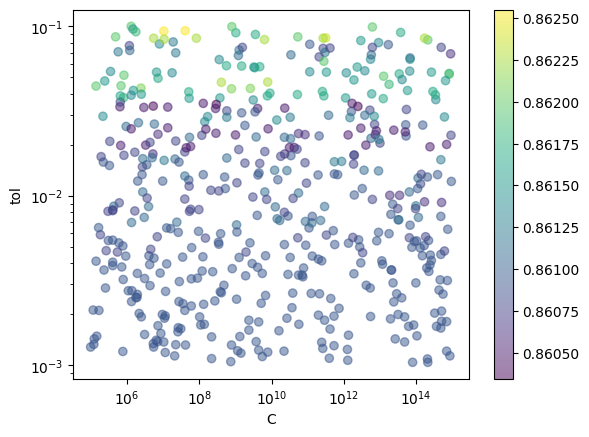

In [33]:
plt.scatter(search_svm.cv_results_['param_C'], search_svm.cv_results_['param_tol'], c=search_svm.cv_results_['mean_test_score'], alpha=0.5)
plt.xlabel('C')
plt.ylabel('tol')
plt.yscale('log')
plt.xscale('log')
plt.colorbar()

El sweet spot está en tol ~ $10^{-2}$, C no cambia mucho. Hacemos las predicciones del held-out con estos parametros pero en un nuevo ```svm.SVC``` con ```probability=True```

In [34]:
modelo_final = svm.SVC(**search_svm.best_params_, probability = True)
modelo_final.fit(X_train, y_train)

SVC(C=10520152.176161591, probability=True, tol=0.09375015015145285)

In [35]:
auc_roc_reportado = metrics.roc_auc_score(y_test, modelo_final.predict_proba(X_test)[:, 1])
auc_roc_reportado

0.9178021978021977

In [36]:
resultados_competencia = pd.DataFrame({'output': modelo_final.predict_proba(X_held_out)[:, 1]})
resultados_competencia['output'] = resultados_competencia.apply(lambda x: f'{x.output:.4f}', axis=1)
resultados_competencia

,output
0,0.4180
1,0.0514
2,0.3010
3,0.1498
4,0.1534
...,...
495,0.0309
496,0.9624
497,0.5513
498,0.0282


In [37]:
resultados_competencia.to_csv(f'04_y_pred_held_out_{int(auc_roc_reportado*1e4)}', index=False)